In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *
from CinemaNet.data_3000L import *
from CinemaNet.custom_head import *

import wandb

In [4]:
model_name = 'MixNet_Large-224x224-3000L'

In [5]:
re.sub('-\d+L', '', model_name)

'MixNet_Large-224x224'

In [6]:
#hide
wandb.init(name=re.sub('-\d+L', '', model_name),
           project='Shot Framing -- Supervised (3000L)',
           tags=['MobileNetV3'],
           entity='synopsis')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/Shot+Framing+--+Supervised+%283000L%29/runs/k3p4zrtj

In [7]:
#hide
%env WANDB_NOTEBOOK_NAME='07-2-MixNet_Large-224x224-3000L.ipynb'

env: WANDB_NOTEBOOK_NAME='07-2-MixNet_Large-224x224-3000L.ipynb'


## Setup

### Dataset

Data grabbing functions in `CinemaNet/data_3000L.py`

In [8]:
img_size   = (224,224)
img_size

(224, 224)

In [9]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Medium Close-Up,Medium Close-Up,Extreme Wide,Close-Up,Extreme Wide
Path: .;

Test: None

6

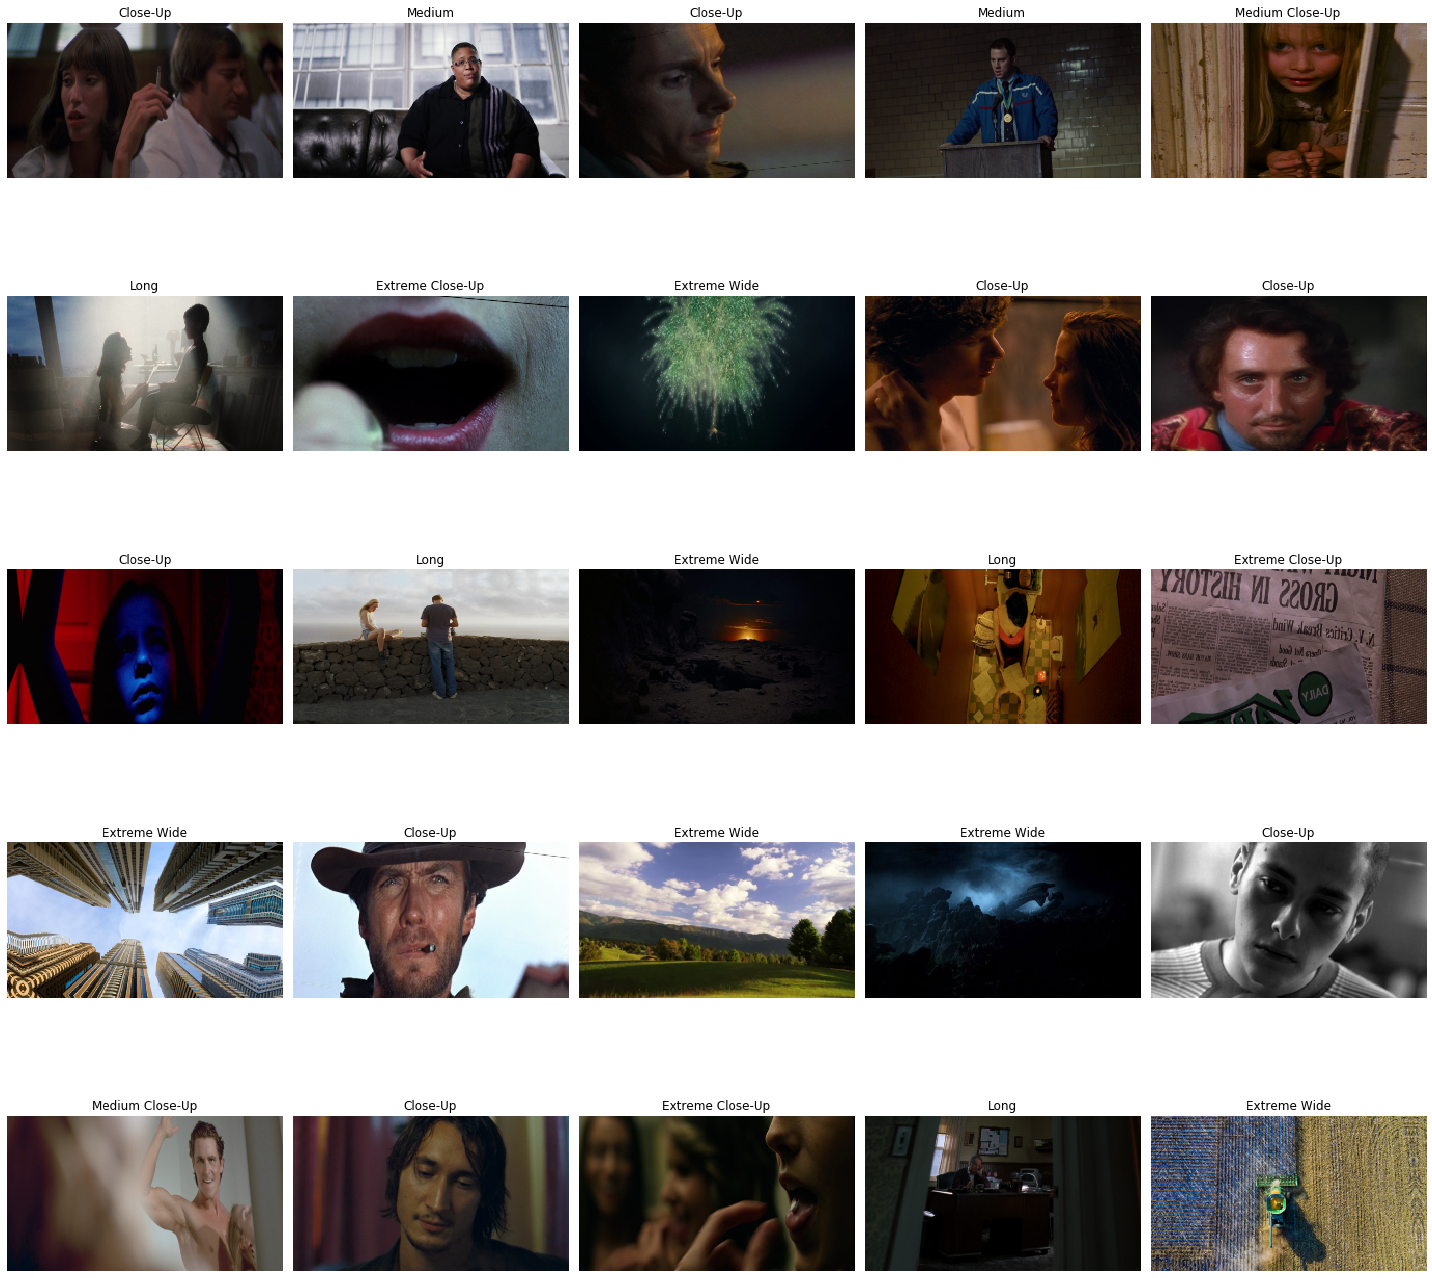

In [9]:
data.c
data.show_batch()

## Training (150, 266)

### Frozen -- Head Only

In [10]:
from geffnet.gen_efficientnet import mixnet_l

In [11]:
mobilenet_split = lambda m: (m[0][3][3][3], m[1])
arch = mixnet_l
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics,
                    cut=None, split_on=mobilenet_split)

[len(grp) for grp in learn.layer_groups]

[142, 146, 10]

In [12]:
learn.model.train();

In [13]:
learn.data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Medium Close-Up,Medium Close-Up,Extreme Wide,Close-Up,Extreme Wide
Path: .;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


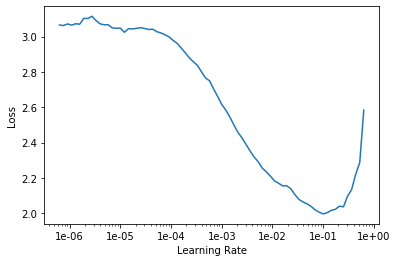

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}', monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [16]:
model_name

'MixNet_Large-224x224-3000L'

In [17]:
callbacks = get_callbacks(learn, model_name, early_stop=False)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,2.123901,1.169310,0.564251,0.565643,0.628646,00:51
1,1.391577,0.878526,0.684380,0.683989,0.722866,00:47
2,1.012996,0.804091,0.710145,0.722597,0.758638,00:46
3,0.771531,0.719828,0.741707,0.753215,0.775093,00:44
4,0.624561,0.671736,0.755233,0.766084,0.789618,00:45
5,0.472899,0.665707,0.758454,0.766487,0.798946,00:47
6,0.398377,0.626845,0.770692,0.783859,0.801020,00:49
7,0.331727,0.638543,0.771337,0.780020,0.809163,00:49
8,0.315975,0.616487,0.773913,0.784714,0.808828,00:48


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.564251184463501.
Better model found at epoch 0 with accuracy value: 0.564251184463501.
Better model found at epoch 1 with accuracy value: 0.684380054473877.
Better model found at epoch 1 with accuracy value: 0.684380054473877.
Better model found at epoch 2 with accuracy value: 0.7101449370384216.
Better model found at epoch 2 with accuracy value: 0.7101449370384216.
Better model found at epoch 3 with accuracy value: 0.741706907749176.
Better model found at epoch 3 with accuracy value: 0.741706907749176.
Better model found at epoch 4 with accuracy value: 0.7552334666252136.
Better model found at epoch 4 with accuracy value: 0.7552334666252136.
Better model found at epoch 5 with accuracy value: 0.7584540843963623.
Better model found at epoch 5 with accuracy value: 0.7584540843963623.
Better model found at epoch 6 with accuracy value: 0.7706924080848694.
Better model found at epoch 6 with accuracy value: 0.7706924080848694.
Better model

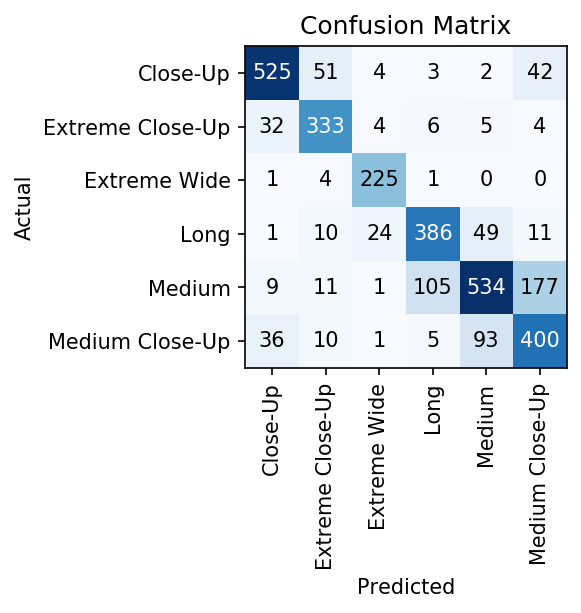

In [18]:
learn.fit_one_cycle(9, 1e-3, callbacks=callbacks)

### Unfrozen

In [20]:
model_name

'MixNet_Large-224x224-3000L'

In [21]:
learn.unfreeze()
model_name = f'{model_name}-unfrozen'
callbacks = get_callbacks(learn, model_name)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


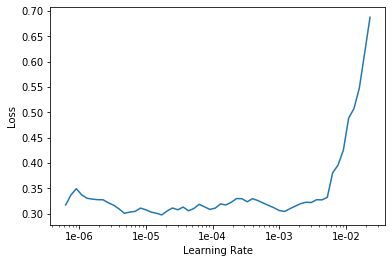

In [22]:
learn.lr_find()
learn.recorder.plot()

In [44]:
callbacks = get_callbacks(learn, model_name, early_stop=False)


epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.296027,0.610541,0.781320,0.790248,0.815386,00:51
1,0.295342,0.599426,0.787118,0.796105,0.818298,00:44
2,0.285450,0.600646,0.786795,0.795049,0.821353,00:44
3,0.274334,0.611392,0.781642,0.788463,0.817222,00:45
4,0.268852,0.614101,0.784219,0.792927,0.816751,00:44
5,0.261830,0.674581,0.775201,0.788815,0.813875,00:44
6,0.249336,0.598042,0.792915,0.803343,0.821714,00:45
7,0.234356,0.600129,0.801610,0.805986,0.828792,00:44
8,0.206742,0.552986,0.810306,0.817336,0.830887,00:46
9,0.202287,0.562835,0.817391,0.828455,0.842387,00:45


Better model found at epoch 0 with accuracy value: 0.7813204526901245.
Better model found at epoch 0 with accuracy value: 0.7813204526901245.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 1 with accuracy value: 0.7871175408363342.
Better model found at epoch 1 with accuracy value: 0.7871175408363342.
Better model found at epoch 6 with accuracy value: 0.792914628982544.
Better model found at epoch 6 with accuracy value: 0.792914628982544.
Better model found at epoch 7 with accuracy value: 0.8016102910041809.
Better model found at epoch 7 with accuracy value: 0.8016102910041809.
Better model found at epoch 8 with accuracy value: 0.8103059530258179.
Better model found at epoch 8 with accuracy value: 0.8103059530258179.
Better model found at epoch 9 with accuracy value: 0.8173912763595581.
Better model found at epoch 9 with accuracy value: 0.8173912763595581.
Better model found at epoch 11 with accuracy value: 0.8193236589431763.
Better model found at epoch 11 with accuracy value: 0.8193236589431763.
Better model found at epoch 13 with accuracy value: 0.8254428505897522.
Better model found at epoch 13 with accuracy value: 0.8254428505897522.
Bett

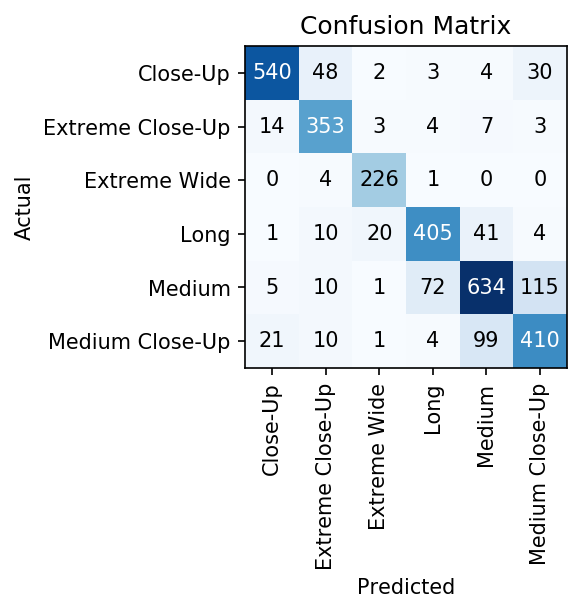

In [23]:
learn.fit_one_cycle(25, slice(1e-6, 1e-3), callbacks=callbacks)


In [24]:
config = wandb.config

config.img_size = img_size
config.batch_size = learn.data.batch_size
config.len_train = len(learn.data.train_ds)
config.len_valid = len(learn.data.valid_ds)
config.model = re.sub('-unfrozen', '', model_name)


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


### Export to CoreML

In [25]:
from CinemaNet.convert import *
from CinemaNet.custom_head import *

In [26]:
model_name

'MixNet_Large-224x224-3000L-unfrozen'

In [27]:
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics,
                    cut=-1, split_on=mobilenet_split)
learn.load(f'{model_name}');


In [28]:
model_fname=re.sub('-unfrozen.*', '', model_name)
model_fname

'MixNet_Large-224x224-3000L'

In [29]:
torch_to_coreml(learn.model, data.c,
                model_fname=model_fname,
                img_size=img_size)

RuntimeError: ONNX export failed: Couldn't export Python operator SwishJitAutoFn

Defined at:
/home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py(48): forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(525): _slow_forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(539): __call__
/home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py(229): forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(525): _slow_forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(539): __call__
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py(92): forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(525): _slow_forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(539): __call__
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py(92): forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(525): _slow_forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(539): __call__
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py(92): forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(525): _slow_forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(539): __call__
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py(92): forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(525): _slow_forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(539): __call__
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/jit/__init__.py(352): forward
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py(541): __call__
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/jit/__init__.py(275): get_trace_graph
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/onnx/utils.py(206): _trace_and_get_graph_from_model
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/onnx/utils.py(249): _model_to_graph
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/onnx/utils.py(382): _export
/home/rahul/anaconda3/lib/python3.7/site-packages/torch/onnx/__init__.py(26): _export
/home/rahul/github_projects/CinemaNet/nbs/CinemaNet/convert.py(20): torch_to_onnx
/home/rahul/github_projects/CinemaNet/nbs/CinemaNet/convert.py(114): torch_to_coreml
<ipython-input-29-0442a0bd370d>(3): <module>
/home/rahul/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3326): run_code
/home/rahul/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249): run_ast_nodes
/home/rahul/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3058): run_cell_async
/home/rahul/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/home/rahul/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2881): _run_cell
/home/rahul/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2855): run_cell
/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py(536): run_cell
/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py(294): do_execute
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py(542): execute_request
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py(272): dispatch_shell
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/gen.py(209): wrapper
/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py(365): process_one
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/gen.py(748): run
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/gen.py(787): inner
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py(743): _run_callback
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py(690): <lambda>
/home/rahul/anaconda3/lib/python3.7/asyncio/events.py(88): _run
/home/rahul/anaconda3/lib/python3.7/asyncio/base_events.py(1771): _run_once
/home/rahul/anaconda3/lib/python3.7/asyncio/base_events.py(534): run_forever
/home/rahul/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py(148): start
/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py(563): start
/home/rahul/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py(664): launch_instance
/home/rahul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py(16): <module>
/home/rahul/anaconda3/lib/python3.7/runpy.py(85): _run_code
/home/rahul/anaconda3/lib/python3.7/runpy.py(193): _run_module_as_main


Graph we tried to export:
graph(%input.1 : Float(1, 3, 224, 224),
      %1 : Float(32, 3, 3, 3),
      %2 : Float(32),
      %3 : Float(32),
      %4 : Float(32),
      %5 : Float(32),
      %6 : Long(),
      %7 : Float(32, 1, 3, 3),
      %8 : Float(32),
      %9 : Float(32),
      %10 : Float(32),
      %11 : Float(32),
      %12 : Long(),
      %13 : Float(32, 32, 1, 1),
      %14 : Float(32),
      %15 : Float(32),
      %16 : Float(32),
      %17 : Float(32),
      %18 : Long(),
      %19 : Float(96, 16, 1, 1),
      %20 : Float(96, 16, 1, 1),
      %21 : Float(192),
      %22 : Float(192),
      %23 : Float(192),
      %24 : Float(192),
      %25 : Long(),
      %26 : Float(64, 1, 3, 3),
      %27 : Float(64, 1, 5, 5),
      %28 : Float(64, 1, 7, 7),
      %29 : Float(192),
      %30 : Float(192),
      %31 : Float(192),
      %32 : Float(192),
      %33 : Long(),
      %34 : Float(20, 96, 1, 1),
      %35 : Float(20, 96, 1, 1),
      %36 : Float(40),
      %37 : Float(40),
      %38 : Float(40),
      %39 : Float(40),
      %40 : Long(),
      %41 : Float(60, 20, 1, 1),
      %42 : Float(60, 20, 1, 1),
      %43 : Float(120),
      %44 : Float(120),
      %45 : Float(120),
      %46 : Float(120),
      %47 : Long(),
      %48 : Float(120, 1, 3, 3),
      %49 : Float(120),
      %50 : Float(120),
      %51 : Float(120),
      %52 : Float(120),
      %53 : Long(),
      %54 : Float(20, 60, 1, 1),
      %55 : Float(20, 60, 1, 1),
      %56 : Float(40),
      %57 : Float(40),
      %58 : Float(40),
      %59 : Float(40),
      %60 : Long(),
      %61 : Float(240, 40, 1, 1),
      %62 : Float(240),
      %63 : Float(240),
      %64 : Float(240),
      %65 : Float(240),
      %66 : Long(),
      %67 : Float(60, 1, 3, 3),
      %68 : Float(60, 1, 5, 5),
      %69 : Float(60, 1, 7, 7),
      %70 : Float(60, 1, 9, 9),
      %71 : Float(240),
      %72 : Float(240),
      %73 : Float(240),
      %74 : Float(240),
      %75 : Long(),
      %76 : Float(20, 240, 1, 1),
      %77 : Float(20),
      %78 : Float(240, 20, 1, 1),
      %79 : Float(240),
      %80 : Float(56, 240, 1, 1),
      %81 : Float(56),
      %82 : Float(56),
      %83 : Float(56),
      %84 : Float(56),
      %85 : Long(),
      %86 : Float(168, 28, 1, 1),
      %87 : Float(168, 28, 1, 1),
      %88 : Float(336),
      %89 : Float(336),
      %90 : Float(336),
      %91 : Float(336),
      %92 : Long(),
      %93 : Float(168, 1, 3, 3),
      %94 : Float(168, 1, 5, 5),
      %95 : Float(336),
      %96 : Float(336),
      %97 : Float(336),
      %98 : Float(336),
      %99 : Long(),
      %100 : Float(28, 336, 1, 1),
      %101 : Float(28),
      %102 : Float(336, 28, 1, 1),
      %103 : Float(336),
      %104 : Float(28, 168, 1, 1),
      %105 : Float(28, 168, 1, 1),
      %106 : Float(56),
      %107 : Float(56),
      %108 : Float(56),
      %109 : Float(56),
      %110 : Long(),
      %111 : Float(168, 28, 1, 1),
      %112 : Float(168, 28, 1, 1),
      %113 : Float(336),
      %114 : Float(336),
      %115 : Float(336),
      %116 : Float(336),
      %117 : Long(),
      %118 : Float(168, 1, 3, 3),
      %119 : Float(168, 1, 5, 5),
      %120 : Float(336),
      %121 : Float(336),
      %122 : Float(336),
      %123 : Float(336),
      %124 : Long(),
      %125 : Float(28, 336, 1, 1),
      %126 : Float(28),
      %127 : Float(336, 28, 1, 1),
      %128 : Float(336),
      %129 : Float(28, 168, 1, 1),
      %130 : Float(28, 168, 1, 1),
      %131 : Float(56),
      %132 : Float(56),
      %133 : Float(56),
      %134 : Float(56),
      %135 : Long(),
      %136 : Float(168, 28, 1, 1),
      %137 : Float(168, 28, 1, 1),
      %138 : Float(336),
      %139 : Float(336),
      %140 : Float(336),
      %141 : Float(336),
      %142 : Long(),
      %143 : Float(168, 1, 3, 3),
      %144 : Float(168, 1, 5, 5),
      %145 : Float(336),
      %146 : Float(336),
      %147 : Float(336),
      %148 : Float(336),
      %149 : Long(),
      %150 : Float(28, 336, 1, 1),
      %151 : Float(28),
      %152 : Float(336, 28, 1, 1),
      %153 : Float(336),
      %154 : Float(28, 168, 1, 1),
      %155 : Float(28, 168, 1, 1),
      %156 : Float(56),
      %157 : Float(56),
      %158 : Float(56),
      %159 : Float(56),
      %160 : Long(),
      %161 : Float(336, 56, 1, 1),
      %162 : Float(336),
      %163 : Float(336),
      %164 : Float(336),
      %165 : Float(336),
      %166 : Long(),
      %167 : Float(112, 1, 3, 3),
      %168 : Float(112, 1, 5, 5),
      %169 : Float(112, 1, 7, 7),
      %170 : Float(336),
      %171 : Float(336),
      %172 : Float(336),
      %173 : Float(336),
      %174 : Long(),
      %175 : Float(14, 336, 1, 1),
      %176 : Float(14),
      %177 : Float(336, 14, 1, 1),
      %178 : Float(336),
      %179 : Float(104, 336, 1, 1),
      %180 : Float(104),
      %181 : Float(104),
      %182 : Float(104),
      %183 : Float(104),
      %184 : Long(),
      %185 : Float(312, 52, 1, 1),
      %186 : Float(312, 52, 1, 1),
      %187 : Float(624),
      %188 : Float(624),
      %189 : Float(624),
      %190 : Float(624),
      %191 : Long(),
      %192 : Float(156, 1, 3, 3),
      %193 : Float(156, 1, 5, 5),
      %194 : Float(156, 1, 7, 7),
      %195 : Float(156, 1, 9, 9),
      %196 : Float(624),
      %197 : Float(624),
      %198 : Float(624),
      %199 : Float(624),
      %200 : Long(),
      %201 : Float(26, 624, 1, 1),
      %202 : Float(26),
      %203 : Float(624, 26, 1, 1),
      %204 : Float(624),
      %205 : Float(52, 312, 1, 1),
      %206 : Float(52, 312, 1, 1),
      %207 : Float(104),
      %208 : Float(104),
      %209 : Float(104),
      %210 : Float(104),
      %211 : Long(),
      %212 : Float(312, 52, 1, 1),
      %213 : Float(312, 52, 1, 1),
      %214 : Float(624),
      %215 : Float(624),
      %216 : Float(624),
      %217 : Float(624),
      %218 : Long(),
      %219 : Float(156, 1, 3, 3),
      %220 : Float(156, 1, 5, 5),
      %221 : Float(156, 1, 7, 7),
      %222 : Float(156, 1, 9, 9),
      %223 : Float(624),
      %224 : Float(624),
      %225 : Float(624),
      %226 : Float(624),
      %227 : Long(),
      %228 : Float(26, 624, 1, 1),
      %229 : Float(26),
      %230 : Float(624, 26, 1, 1),
      %231 : Float(624),
      %232 : Float(52, 312, 1, 1),
      %233 : Float(52, 312, 1, 1),
      %234 : Float(104),
      %235 : Float(104),
      %236 : Float(104),
      %237 : Float(104),
      %238 : Long(),
      %239 : Float(312, 52, 1, 1),
      %240 : Float(312, 52, 1, 1),
      %241 : Float(624),
      %242 : Float(624),
      %243 : Float(624),
      %244 : Float(624),
      %245 : Long(),
      %246 : Float(156, 1, 3, 3),
      %247 : Float(156, 1, 5, 5),
      %248 : Float(156, 1, 7, 7),
      %249 : Float(156, 1, 9, 9),
      %250 : Float(624),
      %251 : Float(624),
      %252 : Float(624),
      %253 : Float(624),
      %254 : Long(),
      %255 : Float(26, 624, 1, 1),
      %256 : Float(26),
      %257 : Float(624, 26, 1, 1),
      %258 : Float(624),
      %259 : Float(52, 312, 1, 1),
      %260 : Float(52, 312, 1, 1),
      %261 : Float(104),
      %262 : Float(104),
      %263 : Float(104),
      %264 : Float(104),
      %265 : Long(),
      %266 : Float(624, 104, 1, 1),
      %267 : Float(624),
      %268 : Float(624),
      %269 : Float(624),
      %270 : Float(624),
      %271 : Long(),
      %272 : Float(624, 1, 3, 3),
      %273 : Float(624),
      %274 : Float(624),
      %275 : Float(624),
      %276 : Float(624),
      %277 : Long(),
      %278 : Float(52, 624, 1, 1),
      %279 : Float(52),
      %280 : Float(624, 52, 1, 1),
      %281 : Float(624),
      %282 : Float(160, 624, 1, 1),
      %283 : Float(160),
      %284 : Float(160),
      %285 : Float(160),
      %286 : Float(160),
      %287 : Long(),
      %288 : Float(240, 80, 1, 1),
      %289 : Float(240, 80, 1, 1),
      %290 : Float(480),
      %291 : Float(480),
      %292 : Float(480),
      %293 : Float(480),
      %294 : Long(),
      %295 : Float(120, 1, 3, 3),
      %296 : Float(120, 1, 5, 5),
      %297 : Float(120, 1, 7, 7),
      %298 : Float(120, 1, 9, 9),
      %299 : Float(480),
      %300 : Float(480),
      %301 : Float(480),
      %302 : Float(480),
      %303 : Long(),
      %304 : Float(80, 480, 1, 1),
      %305 : Float(80),
      %306 : Float(480, 80, 1, 1),
      %307 : Float(480),
      %308 : Float(80, 240, 1, 1),
      %309 : Float(80, 240, 1, 1),
      %310 : Float(160),
      %311 : Float(160),
      %312 : Float(160),
      %313 : Float(160),
      %314 : Long(),
      %315 : Float(240, 80, 1, 1),
      %316 : Float(240, 80, 1, 1),
      %317 : Float(480),
      %318 : Float(480),
      %319 : Float(480),
      %320 : Float(480),
      %321 : Long(),
      %322 : Float(120, 1, 3, 3),
      %323 : Float(120, 1, 5, 5),
      %324 : Float(120, 1, 7, 7),
      %325 : Float(120, 1, 9, 9),
      %326 : Float(480),
      %327 : Float(480),
      %328 : Float(480),
      %329 : Float(480),
      %330 : Long(),
      %331 : Float(80, 480, 1, 1),
      %332 : Float(80),
      %333 : Float(480, 80, 1, 1),
      %334 : Float(480),
      %335 : Float(80, 240, 1, 1),
      %336 : Float(80, 240, 1, 1),
      %337 : Float(160),
      %338 : Float(160),
      %339 : Float(160),
      %340 : Float(160),
      %341 : Long(),
      %342 : Float(240, 80, 1, 1),
      %343 : Float(240, 80, 1, 1),
      %344 : Float(480),
      %345 : Float(480),
      %346 : Float(480),
      %347 : Float(480),
      %348 : Long(),
      %349 : Float(120, 1, 3, 3),
      %350 : Float(120, 1, 5, 5),
      %351 : Float(120, 1, 7, 7),
      %352 : Float(120, 1, 9, 9),
      %353 : Float(480),
      %354 : Float(480),
      %355 : Float(480),
      %356 : Float(480),
      %357 : Long(),
      %358 : Float(80, 480, 1, 1),
      %359 : Float(80),
      %360 : Float(480, 80, 1, 1),
      %361 : Float(480),
      %362 : Float(80, 240, 1, 1),
      %363 : Float(80, 240, 1, 1),
      %364 : Float(160),
      %365 : Float(160),
      %366 : Float(160),
      %367 : Float(160),
      %368 : Long(),
      %369 : Float(960, 160, 1, 1),
      %370 : Float(960),
      %371 : Float(960),
      %372 : Float(960),
      %373 : Float(960),
      %374 : Long(),
      %375 : Float(240, 1, 3, 3),
      %376 : Float(240, 1, 5, 5),
      %377 : Float(240, 1, 7, 7),
      %378 : Float(240, 1, 9, 9),
      %379 : Float(960),
      %380 : Float(960),
      %381 : Float(960),
      %382 : Float(960),
      %383 : Long(),
      %384 : Float(80, 960, 1, 1),
      %385 : Float(80),
      %386 : Float(960, 80, 1, 1),
      %387 : Float(960),
      %388 : Float(264, 960, 1, 1),
      %389 : Float(264),
      %390 : Float(264),
      %391 : Float(264),
      %392 : Float(264),
      %393 : Long(),
      %394 : Float(1584, 264, 1, 1),
      %395 : Float(1584),
      %396 : Float(1584),
      %397 : Float(1584),
      %398 : Float(1584),
      %399 : Long(),
      %400 : Float(396, 1, 3, 3),
      %401 : Float(396, 1, 5, 5),
      %402 : Float(396, 1, 7, 7),
      %403 : Float(396, 1, 9, 9),
      %404 : Float(1584),
      %405 : Float(1584),
      %406 : Float(1584),
      %407 : Float(1584),
      %408 : Long(),
      %409 : Float(132, 1584, 1, 1),
      %410 : Float(132),
      %411 : Float(1584, 132, 1, 1),
      %412 : Float(1584),
      %413 : Float(132, 792, 1, 1),
      %414 : Float(132, 792, 1, 1),
      %415 : Float(264),
      %416 : Float(264),
      %417 : Float(264),
      %418 : Float(264),
      %419 : Long(),
      %420 : Float(1584, 264, 1, 1),
      %421 : Float(1584),
      %422 : Float(1584),
      %423 : Float(1584),
      %424 : Float(1584),
      %425 : Long(),
      %426 : Float(396, 1, 3, 3),
      %427 : Float(396, 1, 5, 5),
      %428 : Float(396, 1, 7, 7),
      %429 : Float(396, 1, 9, 9),
      %430 : Float(1584),
      %431 : Float(1584),
      %432 : Float(1584),
      %433 : Float(1584),
      %434 : Long(),
      %435 : Float(132, 1584, 1, 1),
      %436 : Float(132),
      %437 : Float(1584, 132, 1, 1),
      %438 : Float(1584),
      %439 : Float(132, 792, 1, 1),
      %440 : Float(132, 792, 1, 1),
      %441 : Float(264),
      %442 : Float(264),
      %443 : Float(264),
      %444 : Float(264),
      %445 : Long(),
      %446 : Float(1584, 264, 1, 1),
      %447 : Float(1584),
      %448 : Float(1584),
      %449 : Float(1584),
      %450 : Float(1584),
      %451 : Long(),
      %452 : Float(396, 1, 3, 3),
      %453 : Float(396, 1, 5, 5),
      %454 : Float(396, 1, 7, 7),
      %455 : Float(396, 1, 9, 9),
      %456 : Float(1584),
      %457 : Float(1584),
      %458 : Float(1584),
      %459 : Float(1584),
      %460 : Long(),
      %461 : Float(132, 1584, 1, 1),
      %462 : Float(132),
      %463 : Float(1584, 132, 1, 1),
      %464 : Float(1584),
      %465 : Float(132, 792, 1, 1),
      %466 : Float(132, 792, 1, 1),
      %467 : Float(264),
      %468 : Float(264),
      %469 : Float(264),
      %470 : Float(264),
      %471 : Long(),
      %472 : Float(1536, 264, 1, 1),
      %473 : Float(1536),
      %474 : Float(1536),
      %475 : Float(1536),
      %476 : Float(1536),
      %477 : Long(),
      %478 : Float(3072),
      %479 : Float(3072),
      %480 : Float(3072),
      %481 : Float(3072),
      %482 : Long(),
      %483 : Float(512, 3072),
      %484 : Float(512),
      %485 : Float(512),
      %486 : Float(512),
      %487 : Float(512),
      %488 : Float(512),
      %489 : Long(),
      %490 : Float(6, 512),
      %491 : Float(6)):
  %492 : Float(1, 32, 112, 112) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%input.1, %1), scope: Sequential/Sequential[0]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %493 : Float(1, 32, 112, 112) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%492, %2, %3, %4, %5), scope: Sequential/Sequential[0]/BatchNorm2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %494 : Float(1, 32, 112, 112) = onnx::Relu(%493), scope: Sequential/Sequential[0]/ReLU[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %495 : Float(1, 32, 112, 112) = onnx::Conv[dilations=[1, 1], group=32, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%494, %7), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[0]/DepthwiseSeparableConv[0]/Conv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %496 : Float(1, 32, 112, 112) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%495, %8, %9, %10, %11), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[0]/DepthwiseSeparableConv[0]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %497 : Float(1, 32, 112, 112) = onnx::Relu(%496), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[0]/DepthwiseSeparableConv[0]/ReLU[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %498 : Float(1, 32, 112, 112) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%497, %13), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[0]/DepthwiseSeparableConv[0]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %499 : Float(1, 32, 112, 112) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%498, %14, %15, %16, %17), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[0]/DepthwiseSeparableConv[0]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %500 : Float(1, 32, 112, 112) = onnx::Add(%499, %494), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[0]/DepthwiseSeparableConv[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:181:0
  %input.9 : Float(1, 16, 112, 112), %input.10 : Float(1, 16, 112, 112) = onnx::Split[axis=1, split=[16, 16]](%500)
  %503 : Float(1, 96, 112, 112) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.9, %19), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %504 : Float(1, 96, 112, 112) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.10, %20), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %505 : Float(1, 192, 112, 112) = onnx::Concat[axis=1](%503, %504), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %506 : Float(1, 192, 112, 112) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%505, %21, %22, %23, %24), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %507 : Float(1, 192, 112, 112) = onnx::Relu(%506), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/ReLU[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %input.13 : Float(1, 64, 112, 112), %input.14 : Float(1, 64, 112, 112), %input.15 : Float(1, 64, 112, 112) = onnx::Split[axis=1, split=[64, 64, 64]](%507)
  %511 : Float(1, 64, 56, 56) = onnx::Conv[dilations=[1, 1], group=64, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%input.13, %26), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %512 : Float(1, 64, 56, 56) = onnx::Conv[dilations=[1, 1], group=64, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[2, 2]](%input.14, %27), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %513 : Float(1, 64, 56, 56) = onnx::Conv[dilations=[1, 1], group=64, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[2, 2]](%input.15, %28), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %514 : Float(1, 192, 56, 56) = onnx::Concat[axis=1](%511, %512, %513), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %515 : Float(1, 192, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%514, %29, %30, %31, %32), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %516 : Float(1, 192, 56, 56) = onnx::Relu(%515), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/ReLU[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %input.18 : Float(1, 96, 56, 56), %input.19 : Float(1, 96, 56, 56) = onnx::Split[axis=1, split=[96, 96]](%516)
  %519 : Float(1, 20, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.18, %34), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %520 : Float(1, 20, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.19, %35), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %521 : Float(1, 40, 56, 56) = onnx::Concat[axis=1](%519, %520), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %522 : Float(1, 40, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%521, %36, %37, %38, %39), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[0]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.21 : Float(1, 20, 56, 56), %input.22 : Float(1, 20, 56, 56) = onnx::Split[axis=1, split=[20, 20]](%522)
  %525 : Float(1, 60, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.21, %41), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %526 : Float(1, 60, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.22, %42), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %527 : Float(1, 120, 56, 56) = onnx::Concat[axis=1](%525, %526), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %528 : Float(1, 120, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%527, %43, %44, %45, %46), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %529 : Float(1, 120, 56, 56) = onnx::Relu(%528), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/ReLU[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %530 : Float(1, 120, 56, 56) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%529, %48), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/Conv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %531 : Float(1, 120, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%530, %49, %50, %51, %52), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %532 : Float(1, 120, 56, 56) = onnx::Relu(%531), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/ReLU[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %input.28 : Float(1, 60, 56, 56), %input.29 : Float(1, 60, 56, 56) = onnx::Split[axis=1, split=[60, 60]](%532)
  %535 : Float(1, 20, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.28, %54), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %536 : Float(1, 20, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.29, %55), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %537 : Float(1, 40, 56, 56) = onnx::Concat[axis=1](%535, %536), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %538 : Float(1, 40, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%537, %56, %57, %58, %59), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %539 : Float(1, 40, 56, 56) = onnx::Add(%538, %522), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[1]/InvertedResidual[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %540 : Float(1, 240, 56, 56) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%539, %61), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %541 : Float(1, 240, 56, 56) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%540, %62, %63, %64, %65), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.6 : Float(1, 240, 56, 56) = ^SwishJitAutoFn()(%541), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.33 : Float(1, 60, 56, 56), %input.34 : Float(1, 60, 56, 56), %input.35 : Float(1, 60, 56, 56), %input.36 : Float(1, 60, 56, 56) = onnx::Split[axis=1, split=[60, 60, 60, 60]](%tensor.6)
  %547 : Float(1, 60, 28, 28) = onnx::Conv[dilations=[1, 1], group=60, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%input.33, %67), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %548 : Float(1, 60, 28, 28) = onnx::Conv[dilations=[1, 1], group=60, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[2, 2]](%input.34, %68), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %549 : Float(1, 60, 28, 28) = onnx::Conv[dilations=[1, 1], group=60, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[2, 2]](%input.35, %69), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %550 : Float(1, 60, 28, 28) = onnx::Conv[dilations=[1, 1], group=60, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[2, 2]](%input.36, %70), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %551 : Float(1, 240, 28, 28) = onnx::Concat[axis=1](%547, %548, %549, %550), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %552 : Float(1, 240, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%551, %71, %72, %73, %74), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.38 : Float(1, 240, 28, 28) = ^SwishJitAutoFn()(%552), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %554 : Float(1, 240, 1, 1) = onnx::GlobalAveragePool(%input.38), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %555 : Float(1, 20, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%554, %76, %77), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.40 : Float(1, 20, 1, 1) = ^SwishJitAutoFn()(%555), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %557 : Float(1, 240, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.40, %78, %79), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %558 : Float(1, 240, 1, 1) = onnx::Sigmoid(%557), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %559 : Float(1, 240, 28, 28) = onnx::Mul(%input.38, %558), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %560 : Float(1, 56, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%559, %80), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/Conv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %561 : Float(1, 56, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%560, %81, %82, %83, %84), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[0]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.43 : Float(1, 28, 28, 28), %input.44 : Float(1, 28, 28, 28) = onnx::Split[axis=1, split=[28, 28]](%561)
  %564 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.43, %86), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %565 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.44, %87), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %566 : Float(1, 336, 28, 28) = onnx::Concat[axis=1](%564, %565), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %567 : Float(1, 336, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%566, %88, %89, %90, %91), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.8 : Float(1, 336, 28, 28) = ^SwishJitAutoFn()(%567), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.46 : Float(1, 168, 28, 28), %input.47 : Float(1, 168, 28, 28) = onnx::Split[axis=1, split=[168, 168]](%tensor.8)
  %571 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=168, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.46, %93), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %572 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=168, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.47, %94), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %573 : Float(1, 336, 28, 28) = onnx::Concat[axis=1](%571, %572), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %574 : Float(1, 336, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%573, %95, %96, %97, %98), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.49 : Float(1, 336, 28, 28) = ^SwishJitAutoFn()(%574), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %576 : Float(1, 336, 1, 1) = onnx::GlobalAveragePool(%input.49), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %577 : Float(1, 28, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%576, %100, %101), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.51 : Float(1, 28, 1, 1) = ^SwishJitAutoFn()(%577), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %579 : Float(1, 336, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.51, %102, %103), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %580 : Float(1, 336, 1, 1) = onnx::Sigmoid(%579), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %581 : Float(1, 336, 28, 28) = onnx::Mul(%input.49, %580), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.52 : Float(1, 168, 28, 28), %input.53 : Float(1, 168, 28, 28) = onnx::Split[axis=1, split=[168, 168]](%581)
  %584 : Float(1, 28, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.52, %104), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %585 : Float(1, 28, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.53, %105), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %586 : Float(1, 56, 28, 28) = onnx::Concat[axis=1](%584, %585), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %587 : Float(1, 56, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%586, %106, %107, %108, %109), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %588 : Float(1, 56, 28, 28) = onnx::Add(%587, %561), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %input.55 : Float(1, 28, 28, 28), %input.56 : Float(1, 28, 28, 28) = onnx::Split[axis=1, split=[28, 28]](%588)
  %591 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.55, %111), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %592 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.56, %112), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %593 : Float(1, 336, 28, 28) = onnx::Concat[axis=1](%591, %592), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %594 : Float(1, 336, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%593, %113, %114, %115, %116), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.11 : Float(1, 336, 28, 28) = ^SwishJitAutoFn()(%594), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.58 : Float(1, 168, 28, 28), %input.59 : Float(1, 168, 28, 28) = onnx::Split[axis=1, split=[168, 168]](%tensor.11)
  %598 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=168, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.58, %118), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %599 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=168, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.59, %119), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %600 : Float(1, 336, 28, 28) = onnx::Concat[axis=1](%598, %599), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %601 : Float(1, 336, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%600, %120, %121, %122, %123), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.61 : Float(1, 336, 28, 28) = ^SwishJitAutoFn()(%601), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %603 : Float(1, 336, 1, 1) = onnx::GlobalAveragePool(%input.61), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %604 : Float(1, 28, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%603, %125, %126), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.63 : Float(1, 28, 1, 1) = ^SwishJitAutoFn()(%604), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %606 : Float(1, 336, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.63, %127, %128), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %607 : Float(1, 336, 1, 1) = onnx::Sigmoid(%606), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %608 : Float(1, 336, 28, 28) = onnx::Mul(%input.61, %607), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.64 : Float(1, 168, 28, 28), %input.65 : Float(1, 168, 28, 28) = onnx::Split[axis=1, split=[168, 168]](%608)
  %611 : Float(1, 28, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.64, %129), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %612 : Float(1, 28, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.65, %130), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %613 : Float(1, 56, 28, 28) = onnx::Concat[axis=1](%611, %612), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %614 : Float(1, 56, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%613, %131, %132, %133, %134), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %615 : Float(1, 56, 28, 28) = onnx::Add(%614, %588), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %input.67 : Float(1, 28, 28, 28), %input.68 : Float(1, 28, 28, 28) = onnx::Split[axis=1, split=[28, 28]](%615)
  %618 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.67, %136), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %619 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.68, %137), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %620 : Float(1, 336, 28, 28) = onnx::Concat[axis=1](%618, %619), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %621 : Float(1, 336, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%620, %138, %139, %140, %141), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.14 : Float(1, 336, 28, 28) = ^SwishJitAutoFn()(%621), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.70 : Float(1, 168, 28, 28), %input.71 : Float(1, 168, 28, 28) = onnx::Split[axis=1, split=[168, 168]](%tensor.14)
  %625 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=168, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.70, %143), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %626 : Float(1, 168, 28, 28) = onnx::Conv[dilations=[1, 1], group=168, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.71, %144), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %627 : Float(1, 336, 28, 28) = onnx::Concat[axis=1](%625, %626), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %628 : Float(1, 336, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%627, %145, %146, %147, %148), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.73 : Float(1, 336, 28, 28) = ^SwishJitAutoFn()(%628), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %630 : Float(1, 336, 1, 1) = onnx::GlobalAveragePool(%input.73), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %631 : Float(1, 28, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%630, %150, %151), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.75 : Float(1, 28, 1, 1) = ^SwishJitAutoFn()(%631), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %633 : Float(1, 336, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.75, %152, %153), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %634 : Float(1, 336, 1, 1) = onnx::Sigmoid(%633), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %635 : Float(1, 336, 28, 28) = onnx::Mul(%input.73, %634), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.76 : Float(1, 168, 28, 28), %input.77 : Float(1, 168, 28, 28) = onnx::Split[axis=1, split=[168, 168]](%635)
  %638 : Float(1, 28, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.76, %154), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %639 : Float(1, 28, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.77, %155), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %640 : Float(1, 56, 28, 28) = onnx::Concat[axis=1](%638, %639), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %641 : Float(1, 56, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%640, %156, %157, %158, %159), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %642 : Float(1, 56, 28, 28) = onnx::Add(%641, %615), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[2]/InvertedResidual[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %643 : Float(1, 336, 28, 28) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%642, %161), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %644 : Float(1, 336, 28, 28) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%643, %162, %163, %164, %165), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.16 : Float(1, 336, 28, 28) = ^SwishJitAutoFn()(%644), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.81 : Float(1, 112, 28, 28), %input.82 : Float(1, 112, 28, 28), %input.83 : Float(1, 112, 28, 28) = onnx::Split[axis=1, split=[112, 112, 112]](%tensor.16)
  %649 : Float(1, 112, 14, 14) = onnx::Conv[dilations=[1, 1], group=112, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%input.81, %167), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %650 : Float(1, 112, 14, 14) = onnx::Conv[dilations=[1, 1], group=112, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[2, 2]](%input.82, %168), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %651 : Float(1, 112, 14, 14) = onnx::Conv[dilations=[1, 1], group=112, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[2, 2]](%input.83, %169), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %652 : Float(1, 336, 14, 14) = onnx::Concat[axis=1](%649, %650, %651), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %653 : Float(1, 336, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%652, %170, %171, %172, %173), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.85 : Float(1, 336, 14, 14) = ^SwishJitAutoFn()(%653), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %655 : Float(1, 336, 1, 1) = onnx::GlobalAveragePool(%input.85), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %656 : Float(1, 14, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%655, %175, %176), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.87 : Float(1, 14, 1, 1) = ^SwishJitAutoFn()(%656), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %658 : Float(1, 336, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.87, %177, %178), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %659 : Float(1, 336, 1, 1) = onnx::Sigmoid(%658), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %660 : Float(1, 336, 14, 14) = onnx::Mul(%input.85, %659), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %661 : Float(1, 104, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%660, %179), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/Conv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %662 : Float(1, 104, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%661, %180, %181, %182, %183), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[0]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.90 : Float(1, 52, 14, 14), %input.91 : Float(1, 52, 14, 14) = onnx::Split[axis=1, split=[52, 52]](%662)
  %665 : Float(1, 312, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.90, %185), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %666 : Float(1, 312, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.91, %186), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %667 : Float(1, 624, 14, 14) = onnx::Concat[axis=1](%665, %666), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %668 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%667, %187, %188, %189, %190), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.18 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%668), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.93 : Float(1, 156, 14, 14), %input.94 : Float(1, 156, 14, 14), %input.95 : Float(1, 156, 14, 14), %input.96 : Float(1, 156, 14, 14) = onnx::Split[axis=1, split=[156, 156, 156, 156]](%tensor.18)
  %674 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.93, %192), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %675 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.94, %193), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %676 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.95, %194), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %677 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.96, %195), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %678 : Float(1, 624, 14, 14) = onnx::Concat[axis=1](%674, %675, %676, %677), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %679 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%678, %196, %197, %198, %199), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.98 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%679), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %681 : Float(1, 624, 1, 1) = onnx::GlobalAveragePool(%input.98), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %682 : Float(1, 26, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%681, %201, %202), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.100 : Float(1, 26, 1, 1) = ^SwishJitAutoFn()(%682), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %684 : Float(1, 624, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.100, %203, %204), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %685 : Float(1, 624, 1, 1) = onnx::Sigmoid(%684), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %686 : Float(1, 624, 14, 14) = onnx::Mul(%input.98, %685), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.101 : Float(1, 312, 14, 14), %input.102 : Float(1, 312, 14, 14) = onnx::Split[axis=1, split=[312, 312]](%686)
  %689 : Float(1, 52, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.101, %205), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %690 : Float(1, 52, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.102, %206), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %691 : Float(1, 104, 14, 14) = onnx::Concat[axis=1](%689, %690), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %692 : Float(1, 104, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%691, %207, %208, %209, %210), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %693 : Float(1, 104, 14, 14) = onnx::Add(%692, %662), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %input.104 : Float(1, 52, 14, 14), %input.105 : Float(1, 52, 14, 14) = onnx::Split[axis=1, split=[52, 52]](%693)
  %696 : Float(1, 312, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.104, %212), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %697 : Float(1, 312, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.105, %213), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %698 : Float(1, 624, 14, 14) = onnx::Concat[axis=1](%696, %697), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %699 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%698, %214, %215, %216, %217), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.21 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%699), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.107 : Float(1, 156, 14, 14), %input.108 : Float(1, 156, 14, 14), %input.109 : Float(1, 156, 14, 14), %input.110 : Float(1, 156, 14, 14) = onnx::Split[axis=1, split=[156, 156, 156, 156]](%tensor.21)
  %705 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.107, %219), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %706 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.108, %220), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %707 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.109, %221), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %708 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.110, %222), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %709 : Float(1, 624, 14, 14) = onnx::Concat[axis=1](%705, %706, %707, %708), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %710 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%709, %223, %224, %225, %226), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.112 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%710), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %712 : Float(1, 624, 1, 1) = onnx::GlobalAveragePool(%input.112), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %713 : Float(1, 26, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%712, %228, %229), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.114 : Float(1, 26, 1, 1) = ^SwishJitAutoFn()(%713), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %715 : Float(1, 624, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.114, %230, %231), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %716 : Float(1, 624, 1, 1) = onnx::Sigmoid(%715), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %717 : Float(1, 624, 14, 14) = onnx::Mul(%input.112, %716), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.115 : Float(1, 312, 14, 14), %input.116 : Float(1, 312, 14, 14) = onnx::Split[axis=1, split=[312, 312]](%717)
  %720 : Float(1, 52, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.115, %232), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %721 : Float(1, 52, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.116, %233), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %722 : Float(1, 104, 14, 14) = onnx::Concat[axis=1](%720, %721), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %723 : Float(1, 104, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%722, %234, %235, %236, %237), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %724 : Float(1, 104, 14, 14) = onnx::Add(%723, %693), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %input.118 : Float(1, 52, 14, 14), %input.119 : Float(1, 52, 14, 14) = onnx::Split[axis=1, split=[52, 52]](%724)
  %727 : Float(1, 312, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.118, %239), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %728 : Float(1, 312, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.119, %240), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %729 : Float(1, 624, 14, 14) = onnx::Concat[axis=1](%727, %728), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %730 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%729, %241, %242, %243, %244), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.24 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%730), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.121 : Float(1, 156, 14, 14), %input.122 : Float(1, 156, 14, 14), %input.123 : Float(1, 156, 14, 14), %input.124 : Float(1, 156, 14, 14) = onnx::Split[axis=1, split=[156, 156, 156, 156]](%tensor.24)
  %736 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.121, %246), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %737 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.122, %247), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %738 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.123, %248), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %739 : Float(1, 156, 14, 14) = onnx::Conv[dilations=[1, 1], group=156, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.124, %249), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %740 : Float(1, 624, 14, 14) = onnx::Concat[axis=1](%736, %737, %738, %739), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %741 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%740, %250, %251, %252, %253), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.126 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%741), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %743 : Float(1, 624, 1, 1) = onnx::GlobalAveragePool(%input.126), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %744 : Float(1, 26, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%743, %255, %256), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.128 : Float(1, 26, 1, 1) = ^SwishJitAutoFn()(%744), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %746 : Float(1, 624, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.128, %257, %258), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %747 : Float(1, 624, 1, 1) = onnx::Sigmoid(%746), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %748 : Float(1, 624, 14, 14) = onnx::Mul(%input.126, %747), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.129 : Float(1, 312, 14, 14), %input.130 : Float(1, 312, 14, 14) = onnx::Split[axis=1, split=[312, 312]](%748)
  %751 : Float(1, 52, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.129, %259), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %752 : Float(1, 52, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.130, %260), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %753 : Float(1, 104, 14, 14) = onnx::Concat[axis=1](%751, %752), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %754 : Float(1, 104, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%753, %261, %262, %263, %264), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %755 : Float(1, 104, 14, 14) = onnx::Add(%754, %724), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[3]/InvertedResidual[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %756 : Float(1, 624, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%755, %266), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %757 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%756, %267, %268, %269, %270), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.134 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%757), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %759 : Float(1, 624, 14, 14) = onnx::Conv[dilations=[1, 1], group=624, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.134, %272), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/Conv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %760 : Float(1, 624, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%759, %273, %274, %275, %276), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.136 : Float(1, 624, 14, 14) = ^SwishJitAutoFn()(%760), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %762 : Float(1, 624, 1, 1) = onnx::GlobalAveragePool(%input.136), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %763 : Float(1, 52, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%762, %278, %279), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.138 : Float(1, 52, 1, 1) = ^SwishJitAutoFn()(%763), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %765 : Float(1, 624, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.138, %280, %281), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %766 : Float(1, 624, 1, 1) = onnx::Sigmoid(%765), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %767 : Float(1, 624, 14, 14) = onnx::Mul(%input.136, %766), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %768 : Float(1, 160, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%767, %282), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/Conv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %769 : Float(1, 160, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%768, %283, %284, %285, %286), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[0]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.141 : Float(1, 80, 14, 14), %input.142 : Float(1, 80, 14, 14) = onnx::Split[axis=1, split=[80, 80]](%769)
  %772 : Float(1, 240, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.141, %288), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %773 : Float(1, 240, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.142, %289), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %774 : Float(1, 480, 14, 14) = onnx::Concat[axis=1](%772, %773), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %775 : Float(1, 480, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%774, %290, %291, %292, %293), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.27 : Float(1, 480, 14, 14) = ^SwishJitAutoFn()(%775), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.144 : Float(1, 120, 14, 14), %input.145 : Float(1, 120, 14, 14), %input.146 : Float(1, 120, 14, 14), %input.147 : Float(1, 120, 14, 14) = onnx::Split[axis=1, split=[120, 120, 120, 120]](%tensor.27)
  %781 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.144, %295), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %782 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.145, %296), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %783 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.146, %297), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %784 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.147, %298), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %785 : Float(1, 480, 14, 14) = onnx::Concat[axis=1](%781, %782, %783, %784), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %786 : Float(1, 480, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%785, %299, %300, %301, %302), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.149 : Float(1, 480, 14, 14) = ^SwishJitAutoFn()(%786), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %788 : Float(1, 480, 1, 1) = onnx::GlobalAveragePool(%input.149), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %789 : Float(1, 80, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%788, %304, %305), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.151 : Float(1, 80, 1, 1) = ^SwishJitAutoFn()(%789), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %791 : Float(1, 480, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.151, %306, %307), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %792 : Float(1, 480, 1, 1) = onnx::Sigmoid(%791), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %793 : Float(1, 480, 14, 14) = onnx::Mul(%input.149, %792), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.152 : Float(1, 240, 14, 14), %input.153 : Float(1, 240, 14, 14) = onnx::Split[axis=1, split=[240, 240]](%793)
  %796 : Float(1, 80, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.152, %308), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %797 : Float(1, 80, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.153, %309), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %798 : Float(1, 160, 14, 14) = onnx::Concat[axis=1](%796, %797), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %799 : Float(1, 160, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%798, %310, %311, %312, %313), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %800 : Float(1, 160, 14, 14) = onnx::Add(%799, %769), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %input.155 : Float(1, 80, 14, 14), %input.156 : Float(1, 80, 14, 14) = onnx::Split[axis=1, split=[80, 80]](%800)
  %803 : Float(1, 240, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.155, %315), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %804 : Float(1, 240, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.156, %316), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %805 : Float(1, 480, 14, 14) = onnx::Concat[axis=1](%803, %804), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %806 : Float(1, 480, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%805, %317, %318, %319, %320), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.30 : Float(1, 480, 14, 14) = ^SwishJitAutoFn()(%806), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.158 : Float(1, 120, 14, 14), %input.159 : Float(1, 120, 14, 14), %input.160 : Float(1, 120, 14, 14), %input.161 : Float(1, 120, 14, 14) = onnx::Split[axis=1, split=[120, 120, 120, 120]](%tensor.30)
  %812 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.158, %322), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %813 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.159, %323), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %814 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.160, %324), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %815 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.161, %325), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %816 : Float(1, 480, 14, 14) = onnx::Concat[axis=1](%812, %813, %814, %815), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %817 : Float(1, 480, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%816, %326, %327, %328, %329), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.163 : Float(1, 480, 14, 14) = ^SwishJitAutoFn()(%817), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %819 : Float(1, 480, 1, 1) = onnx::GlobalAveragePool(%input.163), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %820 : Float(1, 80, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%819, %331, %332), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.165 : Float(1, 80, 1, 1) = ^SwishJitAutoFn()(%820), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %822 : Float(1, 480, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.165, %333, %334), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %823 : Float(1, 480, 1, 1) = onnx::Sigmoid(%822), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %824 : Float(1, 480, 14, 14) = onnx::Mul(%input.163, %823), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.166 : Float(1, 240, 14, 14), %input.167 : Float(1, 240, 14, 14) = onnx::Split[axis=1, split=[240, 240]](%824)
  %827 : Float(1, 80, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.166, %335), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %828 : Float(1, 80, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.167, %336), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %829 : Float(1, 160, 14, 14) = onnx::Concat[axis=1](%827, %828), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %830 : Float(1, 160, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%829, %337, %338, %339, %340), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %831 : Float(1, 160, 14, 14) = onnx::Add(%830, %800), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %input.169 : Float(1, 80, 14, 14), %input.170 : Float(1, 80, 14, 14) = onnx::Split[axis=1, split=[80, 80]](%831)
  %834 : Float(1, 240, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.169, %342), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_pw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %835 : Float(1, 240, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.170, %343), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_pw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %836 : Float(1, 480, 14, 14) = onnx::Concat[axis=1](%834, %835), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %837 : Float(1, 480, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%836, %344, %345, %346, %347), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.33 : Float(1, 480, 14, 14) = ^SwishJitAutoFn()(%837), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.172 : Float(1, 120, 14, 14), %input.173 : Float(1, 120, 14, 14), %input.174 : Float(1, 120, 14, 14), %input.175 : Float(1, 120, 14, 14) = onnx::Split[axis=1, split=[120, 120, 120, 120]](%tensor.33)
  %843 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.172, %349), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %844 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.173, %350), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %845 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.174, %351), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %846 : Float(1, 120, 14, 14) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.175, %352), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %847 : Float(1, 480, 14, 14) = onnx::Concat[axis=1](%843, %844, %845, %846), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %848 : Float(1, 480, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%847, %353, %354, %355, %356), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.177 : Float(1, 480, 14, 14) = ^SwishJitAutoFn()(%848), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %850 : Float(1, 480, 1, 1) = onnx::GlobalAveragePool(%input.177), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %851 : Float(1, 80, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%850, %358, %359), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.179 : Float(1, 80, 1, 1) = ^SwishJitAutoFn()(%851), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %853 : Float(1, 480, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.179, %360, %361), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %854 : Float(1, 480, 1, 1) = onnx::Sigmoid(%853), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %855 : Float(1, 480, 14, 14) = onnx::Mul(%input.177, %854), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.180 : Float(1, 240, 14, 14), %input.181 : Float(1, 240, 14, 14) = onnx::Split[axis=1, split=[240, 240]](%855)
  %858 : Float(1, 80, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.180, %362), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %859 : Float(1, 80, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.181, %363), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %860 : Float(1, 160, 14, 14) = onnx::Concat[axis=1](%858, %859), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %861 : Float(1, 160, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%860, %364, %365, %366, %367), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %862 : Float(1, 160, 14, 14) = onnx::Add(%861, %831), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[4]/InvertedResidual[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %863 : Float(1, 960, 14, 14) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%862, %369), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %864 : Float(1, 960, 14, 14) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%863, %370, %371, %372, %373), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.35 : Float(1, 960, 14, 14) = ^SwishJitAutoFn()(%864), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.185 : Float(1, 240, 14, 14), %input.186 : Float(1, 240, 14, 14), %input.187 : Float(1, 240, 14, 14), %input.188 : Float(1, 240, 14, 14) = onnx::Split[axis=1, split=[240, 240, 240, 240]](%tensor.35)
  %870 : Float(1, 240, 7, 7) = onnx::Conv[dilations=[1, 1], group=240, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%input.185, %375), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %871 : Float(1, 240, 7, 7) = onnx::Conv[dilations=[1, 1], group=240, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[2, 2]](%input.186, %376), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %872 : Float(1, 240, 7, 7) = onnx::Conv[dilations=[1, 1], group=240, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[2, 2]](%input.187, %377), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %873 : Float(1, 240, 7, 7) = onnx::Conv[dilations=[1, 1], group=240, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[2, 2]](%input.188, %378), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %874 : Float(1, 960, 7, 7) = onnx::Concat[axis=1](%870, %871, %872, %873), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %875 : Float(1, 960, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%874, %379, %380, %381, %382), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.190 : Float(1, 960, 7, 7) = ^SwishJitAutoFn()(%875), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %877 : Float(1, 960, 1, 1) = onnx::GlobalAveragePool(%input.190), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %878 : Float(1, 80, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%877, %384, %385), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.192 : Float(1, 80, 1, 1) = ^SwishJitAutoFn()(%878), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %880 : Float(1, 960, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.192, %386, %387), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %881 : Float(1, 960, 1, 1) = onnx::Sigmoid(%880), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %882 : Float(1, 960, 7, 7) = onnx::Mul(%input.190, %881), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %883 : Float(1, 264, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%882, %388), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/Conv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %884 : Float(1, 264, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%883, %389, %390, %391, %392), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[0]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %885 : Float(1, 1584, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%884, %394), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %886 : Float(1, 1584, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%885, %395, %396, %397, %398), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.36 : Float(1, 1584, 7, 7) = ^SwishJitAutoFn()(%886), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.197 : Float(1, 396, 7, 7), %input.198 : Float(1, 396, 7, 7), %input.199 : Float(1, 396, 7, 7), %input.200 : Float(1, 396, 7, 7) = onnx::Split[axis=1, split=[396, 396, 396, 396]](%tensor.36)
  %892 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.197, %400), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %893 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.198, %401), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %894 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.199, %402), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %895 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.200, %403), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %896 : Float(1, 1584, 7, 7) = onnx::Concat[axis=1](%892, %893, %894, %895), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %897 : Float(1, 1584, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%896, %404, %405, %406, %407), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.202 : Float(1, 1584, 7, 7) = ^SwishJitAutoFn()(%897), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %899 : Float(1, 1584, 1, 1) = onnx::GlobalAveragePool(%input.202), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %900 : Float(1, 132, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%899, %409, %410), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.204 : Float(1, 132, 1, 1) = ^SwishJitAutoFn()(%900), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %902 : Float(1, 1584, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.204, %411, %412), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %903 : Float(1, 1584, 1, 1) = onnx::Sigmoid(%902), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %904 : Float(1, 1584, 7, 7) = onnx::Mul(%input.202, %903), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.205 : Float(1, 792, 7, 7), %input.206 : Float(1, 792, 7, 7) = onnx::Split[axis=1, split=[792, 792]](%904)
  %907 : Float(1, 132, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.205, %413), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %908 : Float(1, 132, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.206, %414), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %909 : Float(1, 264, 7, 7) = onnx::Concat[axis=1](%907, %908), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %910 : Float(1, 264, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%909, %415, %416, %417, %418), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %911 : Float(1, 264, 7, 7) = onnx::Add(%910, %884), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %912 : Float(1, 1584, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%911, %420), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %913 : Float(1, 1584, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%912, %421, %422, %423, %424), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.38 : Float(1, 1584, 7, 7) = ^SwishJitAutoFn()(%913), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.210 : Float(1, 396, 7, 7), %input.211 : Float(1, 396, 7, 7), %input.212 : Float(1, 396, 7, 7), %input.213 : Float(1, 396, 7, 7) = onnx::Split[axis=1, split=[396, 396, 396, 396]](%tensor.38)
  %919 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.210, %426), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %920 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.211, %427), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %921 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.212, %428), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %922 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.213, %429), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %923 : Float(1, 1584, 7, 7) = onnx::Concat[axis=1](%919, %920, %921, %922), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %924 : Float(1, 1584, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%923, %430, %431, %432, %433), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.215 : Float(1, 1584, 7, 7) = ^SwishJitAutoFn()(%924), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %926 : Float(1, 1584, 1, 1) = onnx::GlobalAveragePool(%input.215), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %927 : Float(1, 132, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%926, %435, %436), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.217 : Float(1, 132, 1, 1) = ^SwishJitAutoFn()(%927), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %929 : Float(1, 1584, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.217, %437, %438), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %930 : Float(1, 1584, 1, 1) = onnx::Sigmoid(%929), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %931 : Float(1, 1584, 7, 7) = onnx::Mul(%input.215, %930), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.218 : Float(1, 792, 7, 7), %input.219 : Float(1, 792, 7, 7) = onnx::Split[axis=1, split=[792, 792]](%931)
  %934 : Float(1, 132, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.218, %439), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %935 : Float(1, 132, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.219, %440), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %936 : Float(1, 264, 7, 7) = onnx::Concat[axis=1](%934, %935), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %937 : Float(1, 264, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%936, %441, %442, %443, %444), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %938 : Float(1, 264, 7, 7) = onnx::Add(%937, %911), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %939 : Float(1, 1584, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%938, %446), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/Conv2d[conv_pw] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %940 : Float(1, 1584, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%939, %447, %448, %449, %450), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/BatchNorm2d[bn1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %tensor.40 : Float(1, 1584, 7, 7) = ^SwishJitAutoFn()(%940), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %input.223 : Float(1, 396, 7, 7), %input.224 : Float(1, 396, 7, 7), %input.225 : Float(1, 396, 7, 7), %input.226 : Float(1, 396, 7, 7) = onnx::Split[axis=1, split=[396, 396, 396, 396]](%tensor.40)
  %946 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%input.223, %452), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %947 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%input.224, %453), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %948 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[7, 7], pads=[3, 3, 3, 3], strides=[1, 1]](%input.225, %454), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %949 : Float(1, 396, 7, 7) = onnx::Conv[dilations=[1, 1], group=396, kernel_shape=[9, 9], pads=[4, 4, 4, 4], strides=[1, 1]](%input.226, %455), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_dw]/Conv2d[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %950 : Float(1, 1584, 7, 7) = onnx::Concat[axis=1](%946, %947, %948, %949), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_dw] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %951 : Float(1, 1584, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%950, %456, %457, %458, %459), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/BatchNorm2d[bn2] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %input.228 : Float(1, 1584, 7, 7) = ^SwishJitAutoFn()(%951), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SwishJit[act2] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %953 : Float(1, 1584, 1, 1) = onnx::GlobalAveragePool(%input.228), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SqueezeExcite[se]/AdaptiveAvgPool2d[avg_pool] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %954 : Float(1, 132, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%953, %461, %462), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_reduce] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %input.230 : Float(1, 132, 1, 1) = ^SwishJitAutoFn()(%954), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SqueezeExcite[se]/SwishJit[act1] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations_jit.py:48:0
  %956 : Float(1, 1584, 1, 1) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.230, %463, %464), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SqueezeExcite[se]/Conv2d[conv_expand] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %957 : Float(1, 1584, 1, 1) = onnx::Sigmoid(%956), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/activations/activations.py:37:0
  %958 : Float(1, 1584, 7, 7) = onnx::Mul(%input.228, %957), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/SqueezeExcite[se] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:112:0
  %input.231 : Float(1, 792, 7, 7), %input.232 : Float(1, 792, 7, 7) = onnx::Split[axis=1, split=[792, 792]](%958)
  %961 : Float(1, 132, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.231, %465), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[0] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %962 : Float(1, 132, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%input.232, %466), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_pwl]/Conv2d[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %963 : Float(1, 264, 7, 7) = onnx::Concat[axis=1](%961, %962), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/MixedConv2d[conv_pwl] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/conv2d_layers.py:177:0
  %964 : Float(1, 264, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%963, %467, %468, %469, %470), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3]/BatchNorm2d[bn3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %965 : Float(1, 264, 7, 7) = onnx::Add(%964, %938), scope: Sequential/Sequential[0]/Sequential[3]/Sequential[5]/InvertedResidual[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/geffnet/efficientnet_builder.py:246:0
  %966 : Float(1, 1536, 7, 7) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%965, %472), scope: Sequential/Sequential[0]/Conv2d[4] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py:342:0
  %967 : Float(1, 1536, 7, 7) = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%966, %473, %474, %475, %476), scope: Sequential/Sequential[0]/BatchNorm2d[5] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1670:0
  %968 : Float(1, 1536, 7, 7) = onnx::Relu(%967), scope: Sequential/Sequential[0]/ReLU[6] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %969 : Float(1, 1536, 1, 1) = onnx::GlobalAveragePool(%968), scope: Sequential/Sequential[0]/AdaptiveAvgPool2d[7] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %970 : Float(1, 1536, 1, 1) = onnx::MaxPool[kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%969), scope: Sequential/Sequential[1]/AdaptiveConcatPool2d[0]/AdaptiveMaxPool2d[mp] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:695:0
  %971 : Float(1, 1536, 1, 1) = onnx::GlobalAveragePool(%969), scope: Sequential/Sequential[1]/AdaptiveConcatPool2d[0]/AdaptiveAvgPool2d[ap] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:768:0
  %972 : Float(1, 3072, 1, 1) = onnx::Concat[axis=1](%970, %971), scope: Sequential/Sequential[1]/AdaptiveConcatPool2d[0] # /home/rahul/fastai/fastai/layers.py:184:0
  %973 : Float(1, 3072) = onnx::Flatten[axis=1](%972), scope: Sequential/Sequential[1]/Flatten[1] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/modules/flatten.py:29:0
  %974 : Tensor = onnx::Unsqueeze[axes=[2]](%973), scope: Sequential/Sequential[1]/BatchNorm1d[2]
  %975 : Tensor = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%974, %478, %479, %480, %481), scope: Sequential/Sequential[1]/BatchNorm1d[2]
  %976 : Float(1, 3072) = onnx::Squeeze[axes=[2]](%975), scope: Sequential/Sequential[1]/Dropout[3] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:807:0
  %977 : Float(1, 512) = onnx::Gemm[alpha=1, beta=1, transB=1](%976, %483, %484), scope: Sequential/Sequential[1]/Linear[4] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1370:0
  %978 : Float(1, 512) = onnx::Relu(%977), scope: Sequential/Sequential[1]/ReLU[5] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:912:0
  %979 : Tensor = onnx::Unsqueeze[axes=[2]](%978), scope: Sequential/Sequential[1]/BatchNorm1d[6]
  %980 : Tensor = onnx::BatchNormalization[epsilon=1e-05, momentum=0.9](%979, %485, %486, %487, %488), scope: Sequential/Sequential[1]/BatchNorm1d[6]
  %981 : Float(1, 512) = onnx::Squeeze[axes=[2]](%980), scope: Sequential/Sequential[1]/Dropout[7] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:807:0
  %982 : Float(1, 6) = onnx::Gemm[alpha=1, beta=1, transB=1](%981, %490, %491), scope: Sequential/Sequential[1]/Linear[8] # /home/rahul/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1370:0
  return (%982)


In [30]:
!ls -l ../{model_fname}*

-rw-rw-r-- 1 rahul rahul  536 Jan 22 10:59 ../MixNet_Large-224x224-3000L-history.csv
-rw-rw-r-- 1 rahul rahul 1129 Jan 22 11:19 ../MixNet_Large-224x224-3000L-unfrozen-history.csv


In [31]:
!ls -l ../exported-models/{model_fname}*

ls: cannot access '../exported-models/MixNet_Large-224x224-3000L*': No such file or directory


In [32]:
wandb.save(f'../exported-models/{model_fname}*')
#wandb.save(f'../{model_fname}*')


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


[]